# Gaussian track hit predictions with LSTMs

In this notebook we evaluate a model which, given a hit sequence, predicts the location of the next hit as a Gaussian probability distribution. By extending the basic single-value prediction (trained with regression) in this way we produce a model which can quantify its uncertainty and give more meaningful probability scores to hits in track building.

To parametrize the Gaussian predictions, the model produces predictions for the means (2 values) and a covariance matrix (3 independent values). The model is then trained using a Gaussian log-likelihood loss function, given by:

$L(x,y) = \log{|\Sigma|} + (y - f(x))^{\rm T}\Sigma^{-1}(y-f(x))$

The model was pre-trained on ACTS data. Here we evaluate the model on a test set and make some plots.

In [1]:
from __future__ import print_function

# System imports
import os

# Data libraries
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal

# Torch imports
import torch

# Visualization
import matplotlib.pyplot as plt

# Local imports
import torchutils
torchutils.set_cuda(False)
from torchutils import np_to_torch, torch_to_np
from track_filter import coord_scale

# Magic
%matplotlib notebook

## Read the data

In [2]:
def prepare_model_data(data):
    """
    Put a chunk of numpy data into format for the model.
    Reshapes and slices out the input and target features,
    and converts into PyTorch Variable format.    
    """
    # All but last detector layer used as inputs
    inputs = np_to_torch(data[:, :-1])
    # Target includes all but first layer, and drops the layer feature
    targets = np_to_torch(data[:, 1:, :-1])
    return inputs, targets

In [3]:
ls /global/cscratch1/sd/sfarrell/heptrkx/

RNNFilter/                    RNNGausFilter_20180110_1144/
RNNFilter-2/                  RNNGausFilter_20180205_1120/
RNNFilter_005/                RNNGausFilter_20180205_1120_1/
RNNFilter_006/                RNNGausFilter_20180205_1120_2/
RNNFilter_20171212_1455/      RNNGausFilter_20180205_1120_3/
RNNFilter_20180202_1422/      RNNGausFilter_20180205_1120_4/
RNNFilter_20180202_1915/      RNNGausFilter_20180205_1120_5/
RNNFilter_20180203_2242/      filter_data_005/
RNNGausFilter_010/            filter_data_006/
RNNGausFilter_011/            track_clf_data_000/
RNNGausFilter_012/            track_clf_data_001/
RNNGausFilter_20171215_1130/


In [4]:
data_dir = '/global/cscratch1/sd/sfarrell/heptrkx/filter_data_005'
train_dir = '/global/cscratch1/sd/sfarrell/heptrkx/RNNGausFilter_012'
#train_dir = '/global/cscratch1/sd/sfarrell/heptrkx/RNNGausFilter_20180205_1120_5'
#train_dir = '/global/cscratch1/sd/sfarrell/heptrkx/RNNGausFilter_20171215_1130'
model_file = os.path.join(train_dir, 'model')
losses_file = os.path.join(train_dir, 'losses.npz')

In [5]:
#train_data = np.load(os.path.join(data_dir, 'train_data.npy'))
test_data = np.load(os.path.join(data_dir, 'test_data.npy'))

losses_data = np.load(losses_file)
train_losses = losses_data['train_losses']
valid_losses = losses_data['valid_losses']

# Load the pre-trained model
model = torch.load(model_file)
model.eval()
model

HitGausPredictor(
  (lstm): LSTM(3, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5)
)

In [6]:
# Prepare data into input/output
test_input, test_target = prepare_model_data(test_data)

## Loss curves

<IPython.core.display.Javascript object>


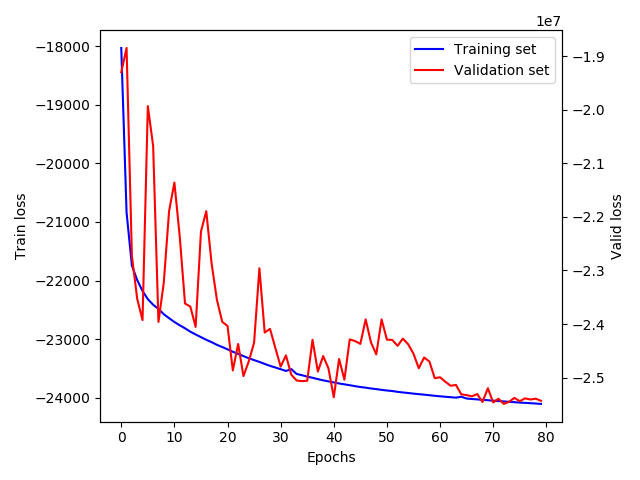

In [7]:
plt.figure()
p1, = plt.plot(np.array(train_losses), c='b', label='Training set')
plt.ylabel('Train loss')
plt.xlabel('Epochs')
plt.twinx()
p2, = plt.plot(np.array(valid_losses), c='r', label='Validation set')
plt.ylabel('Valid loss')
plt.legend([p1, p2], ['Training set', 'Validation set'])
plt.tight_layout()

## Evaluate model performance

Understanding the loss is a bit difficult. I need to provide some additional metrics.

In [8]:
test_output = model(test_input)

### Visualizing predictions

In [9]:
cov_scale = coord_scale[:2, None] * coord_scale[None, :2]

<IPython.core.display.Javascript object>


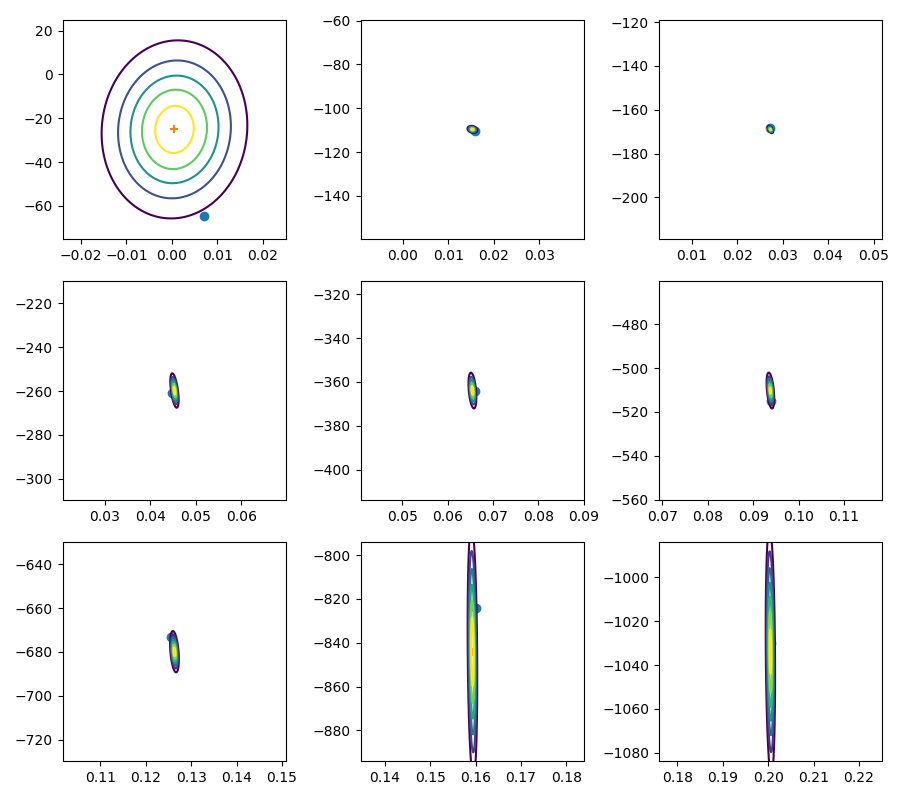

In [10]:
# Pick out the values to draw
isample = 0
mus = torch_to_np(test_output[0][isample]) * coord_scale[:2]
covs = torch_to_np(test_output[1][isample]) * cov_scale
targets = torch_to_np(test_target[isample]) * coord_scale[:2]

# Draw figure with 9 subplots (3x3) for the predictions on each layer
plt.figure(figsize=(9,8))

for ilay in range(9):
    plt.subplot(3, 3, ilay+1)
    # Construct a gaussian from our prediction
    pred = multivariate_normal(mus[ilay], covs[ilay])
    
    # Compute values on a grid
    wsize = np.array([np.pi/128, 50])
    wlow, whigh = mus[ilay] - wsize, mus[ilay] + wsize
    phi_grid, z_grid = np.mgrid[wlow[0]:whigh[0]:.0001, wlow[1]:whigh[1]:.1]
    pred_grid = pred.pdf(np.dstack([phi_grid, z_grid]))
    
    # Draw the predicted gaussian
    c = plt.contour(phi_grid, z_grid, pred_grid)
    # Draw the actual hit location
    plt.scatter(targets[ilay, 0], targets[ilay, 1])
    # Draw the mean prediction
    plt.scatter(mus[ilay, 0], mus[ilay, 1], marker='+')

plt.tight_layout()

<IPython.core.display.Javascript object>


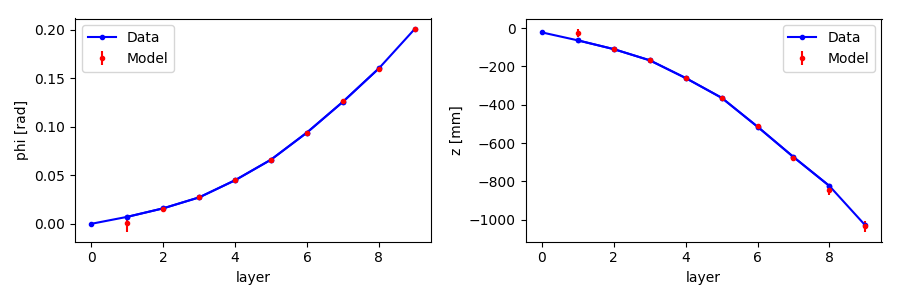

<IPython.core.display.Javascript object>


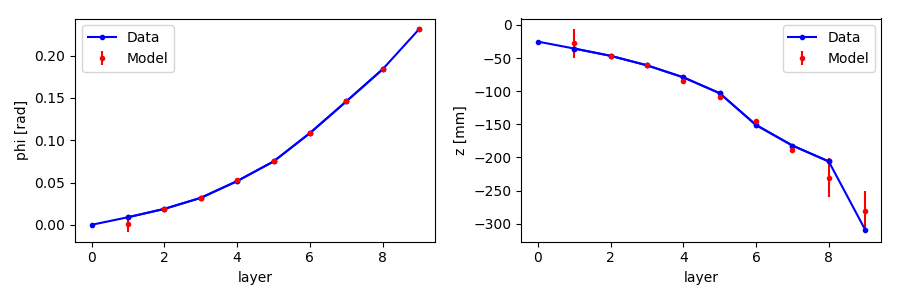

<IPython.core.display.Javascript object>


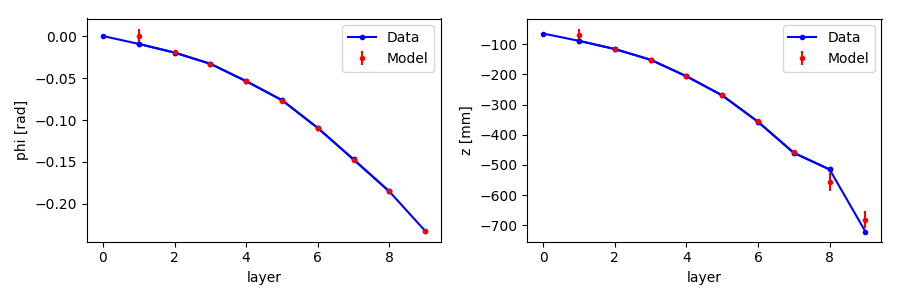

<IPython.core.display.Javascript object>


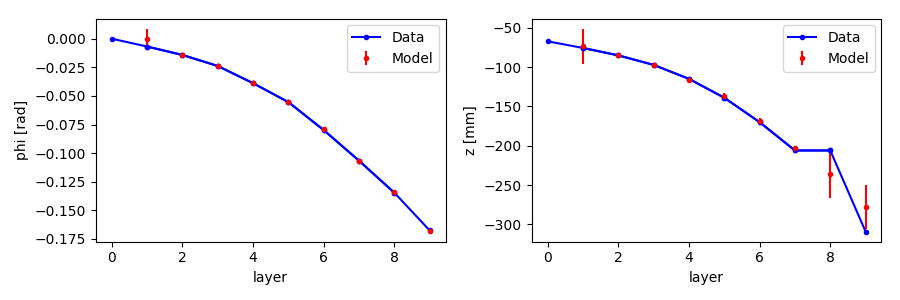

In [11]:
layers = np.arange(10)

# Loop over a few samples to draw
for isample in range(4):

    inputs = torch_to_np(test_input[isample]) * coord_scale
    targets = torch_to_np(test_target[isample]) * coord_scale[:2]
    pred_mus = torch_to_np(test_output[0][isample]) * coord_scale[:2]
    pred_covs = torch_to_np(test_output[1][isample]) * cov_scale

    pred_phi = pred_mus[:, 0]
    pred_z = pred_mus[:, 1]
    pred_phi_sig = np.sqrt(pred_covs[:,0,0])
    pred_z_sig = np.sqrt(pred_covs[:,1,1])

    # Draw the means first
    plt.figure(figsize=(9,3))
    plt.subplot(121)
    plt.plot(layers[:-1], inputs[:, 0], 'b.-')
    plt.plot(layers[1:], targets[:,0], 'b.-', label='Data')
    plt.errorbar(layers[1:], pred_phi, yerr=pred_phi_sig, fmt='r.', label='Model')
    plt.xlabel('layer')
    plt.ylabel('phi [rad]')
    plt.legend(loc=0)

    plt.subplot(122)
    plt.plot(layers[:-1], inputs[:, 1], 'b.-')
    plt.plot(layers[1:], targets[:, 1], 'b.-', label='Data')
    plt.errorbar(layers[1:], pred_z, yerr=pred_z_sig, fmt='r.', label='Model')
    plt.xlabel('layer')
    plt.ylabel('z [mm]')
    plt.legend(loc=0)

    plt.tight_layout()

In [12]:
def calc_residuals(preds, targets):
    """
    Calculates the residuals errors for phi and z coordinates.
    Corrects for the delta-phi discontinuity.
    """
    res = preds - targets
    # fix the delta-phi calculation around the discontinuity
    res[res[:,:,0] > np.pi, 0] -= 2*np.pi
    res[res[:,:,0] < -np.pi, 0] += 2*np.pi
    return res

In [13]:
# Extract the test set data, errors, pulls
preds = torch_to_np(test_output[0]) * coord_scale[:2]
sigmas = np.sqrt(np.diagonal(torch_to_np(test_output[1]), axis1=2, axis2=3)) * coord_scale[:2]
targets = torch_to_np(test_target) * coord_scale[:2]
residuals = calc_residuals(preds, targets)
pulls = residuals / sigmas

In [14]:
# Fit the pull distributions
phi_pulls = pulls[:, :, 0].flatten()
z_pulls = pulls[:, :, 1].flatten()
fit_x = np.linspace(-5, 5)

phi_pull_mu, phi_pull_std = norm.fit(phi_pulls)
phi_pull_fit = norm.pdf(fit_x, phi_pull_mu, phi_pull_std)

z_pull_mu, z_pull_std = norm.fit(z_pulls)
z_pull_fit = norm.pdf(fit_x, z_pull_mu, z_pull_std)

<IPython.core.display.Javascript object>


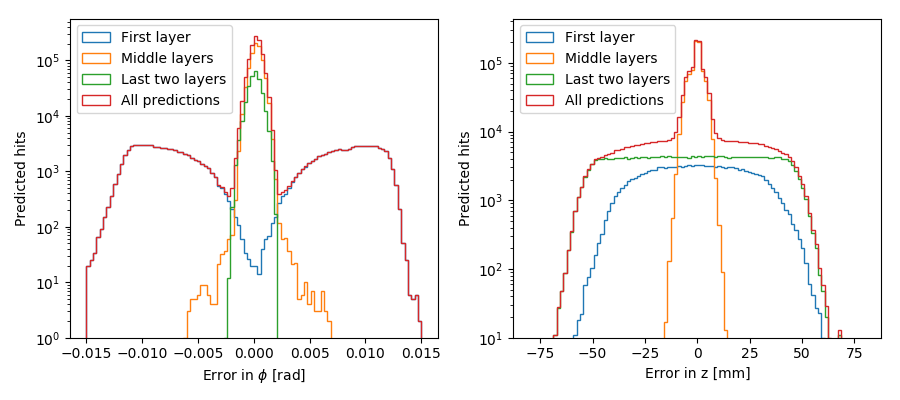

In [15]:
plt.figure(figsize=(9,4))
plt.subplot(121)
hist_args = dict(bins=100, range=(-0.015, 0.015),
                 normed=False, log=True, histtype='step')
# Draw errors on first, last, and all prediction layers separately
plt.hist(residuals[:,:1,0].flatten(), label='First layer', **hist_args)
plt.hist(residuals[:,1:-2,0].flatten(), label='Middle layers', **hist_args)
plt.hist(residuals[:,-2:,0].flatten(), label='Last two layers', **hist_args)
plt.hist(residuals[:,:,0].flatten(), label='All predictions', **hist_args)
plt.xlabel('Error in $\phi$ [rad]')
plt.ylabel('Predicted hits')
plt.ylim(ymin=1)
plt.legend(loc=2)

plt.subplot(122)
hist_args = dict(bins=100, range=(-80, 80),
                 normed=False, log=True, histtype='step')
plt.hist(residuals[:,:1,1].flatten(), label='First layer', **hist_args)
plt.hist(residuals[:,1:-2,1].flatten(), label='Middle layers', **hist_args)
plt.hist(residuals[:,-2:,1].flatten(), label='Last two layers', **hist_args)
plt.hist(residuals[:,:,1].flatten(), label='All predictions', **hist_args)
plt.xlabel('Error in z [mm]')
plt.ylabel('Predicted hits')
plt.ylim(ymin=10)
plt.legend(loc=2)
plt.tight_layout()

<IPython.core.display.Javascript object>


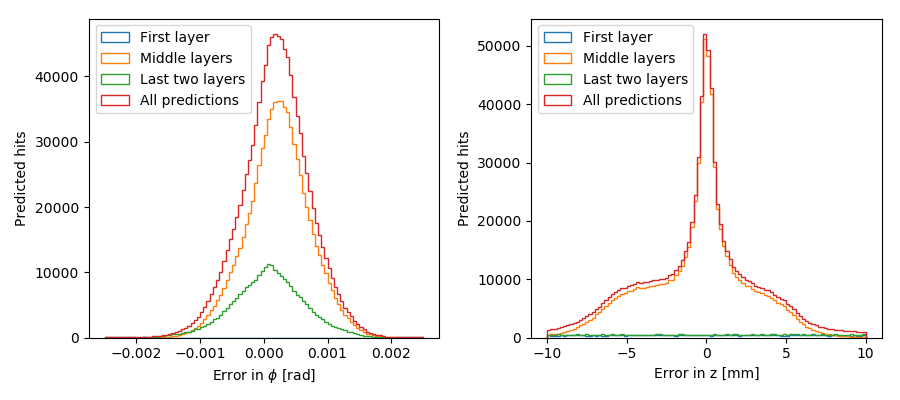

In [16]:
plt.figure(figsize=(9,4))
plt.subplot(121)
hist_args = dict(bins=100, range=(-0.0025, 0.0025),
                 normed=False, log=False, histtype='step')
# Draw errors on first, last, and all prediction layers separately
plt.hist(residuals[:,:1,0].flatten(), label='First layer', **hist_args)
plt.hist(residuals[:,1:-2,0].flatten(), label='Middle layers', **hist_args)
plt.hist(residuals[:,-2:,0].flatten(), label='Last two layers', **hist_args)
plt.hist(residuals[:,:,0].flatten(), label='All predictions', **hist_args)
plt.xlabel('Error in $\phi$ [rad]')
plt.ylabel('Predicted hits')
#plt.ylim(ymin=1)
plt.legend(loc=2)

plt.subplot(122)
hist_args = dict(bins=100, range=(-10, 10),
                 normed=False, log=False, histtype='step')
plt.hist(residuals[:,:1,1].flatten(), label='First layer', **hist_args)
plt.hist(residuals[:,1:-2,1].flatten(), label='Middle layers', **hist_args)
plt.hist(residuals[:,-2:,1].flatten(), label='Last two layers', **hist_args)
plt.hist(residuals[:,:,1].flatten(), label='All predictions', **hist_args)
plt.xlabel('Error in z [mm]')
plt.ylabel('Predicted hits')
#plt.ylim(ymin=10)
plt.legend(loc=2)
plt.tight_layout()

<IPython.core.display.Javascript object>


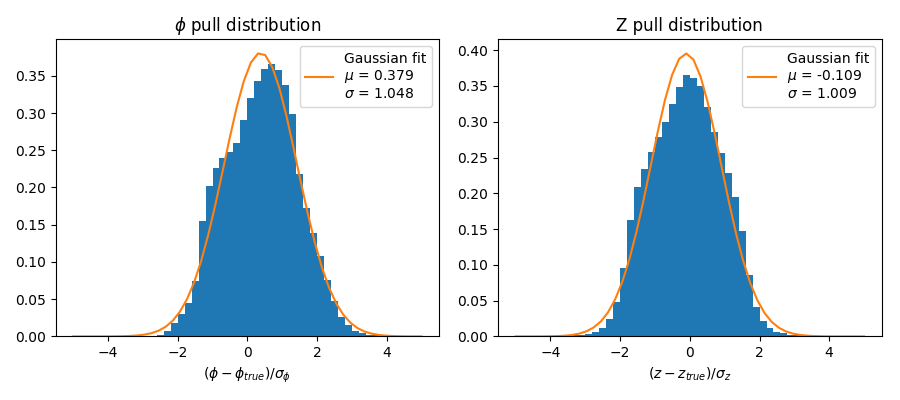

In [17]:
# Draw the pull distributions
plt.figure(figsize=(9,4))

plt.subplot(121)
plt.hist(phi_pulls, bins=50, range=[-5, 5], normed=True)
fit_label = 'Gaussian fit\n$\mu$ = %.3f\n$\sigma$ = %.3f' % (phi_pull_mu, phi_pull_std)
plt.plot(fit_x, phi_pull_fit, label=fit_label)
plt.xlabel('$(\phi - \phi_{true}) / \sigma_\phi$')
plt.title('$\phi$ pull distribution')
plt.legend(loc=0)

plt.subplot(122)
plt.hist(z_pulls, bins=50, range=[-5, 5], normed=True)
fit_label = 'Gaussian fit\n$\mu$ = %.3f\n$\sigma$ = %.3f' % (z_pull_mu, z_pull_std)
plt.plot(fit_x, z_pull_fit, label=fit_label)
plt.xlabel('$(z - z_{true}) / \sigma_z$')
plt.title('Z pull distribution')
plt.legend(loc=0)

plt.tight_layout()

## Discussion

This model seems to be able to learn trajectories better than the simpler one which only predicts a central value with an MSE loss, which is a rather interesting thing.

It's still not perfect, certainly. The shapes of the errors and pulls vary a bit as I modify things, which suggests instability or lack of convergence. The residuals and pull distributions show some tails and biases, though the size of the uncertainties predicted by the model seem to match the errors when applied to data, which is good.

The loss during training seems a little unstable, which could be related to the biases observed above. I may be able to improve this.